# **Week 3: Noise**

Procedural noise is a type of computer-generated noise that is used in various applications such as computer graphics, simulation, and procedural generation. It is a mathematical function that generates a random or pseudo-random sequence of values that appear to be random and irregular but are actually deterministic.

We will first have a look at Morton code, also known as a Z-order curve, which is a way of mapping multidimensional data to a one-dimensional sequence. It is commonly used in computer graphics and spatial indexing to efficiently store and retrieve data.

We will then move on to implementations of different procedural noise types:

One of the most popular types of procedural noise is **Perlin noise**, which was developed by Ken Perlin in 1985 for use in the film industry. Perlin noise generates a smooth, continuous gradient of values that can be used to create natural-looking textures, clouds, and terrain.

**Periodic noise** is another type of procedural noise that generates a repeating pattern of values. It is useful for creating textures and patterns that repeat in a regular way, such as wood grain or brick walls.

Another type of procedural noise is **Worley noise**, also known as cellular noise or Voronoi noise, which generates a pattern of irregularly shaped cells that can be used to create a variety of effects, such as crackle patterns and rock formations.

**The second programming assignment of the course given at the end of the notebook will challenge you to implement curl noise in Python.**

- Preamble is where we import the Python modules that we will use
- In order to make things easies, we will use the Python package `random`
- We will also use the function `isclose()` from `math` to check whether a number is *practically* zero.

In [ ]:
import numpy as np
import sys
from random import seed, randint
import matplotlib.pyplot as plt
from math import isclose
from scipy.spatial.distance import chebyshev as cheby

- We will also use LCG in a single instance, so we will include a simplified version here for convenience

In [ ]:
def lcg(modulus, a, c, seed):
    seed = (a * seed + c) % modulus
    return seed

# Morton Code

- Morton code, also known as a Z-order curve, is a way of mapping multidimensional data to a one-dimensional sequence. It was invented by Guy Macdonald Morton in the 1960s as a method for efficiently indexing multi-dimensional data.
- `morton()` takes an array `Z` of integers as input and returns their Morton code as an integer. If the optional argument b is not given, it is calculated as the maximum number of bits required to represent any element of Z. The Morton code is calculated by interleaving the bits of each element of Z and combining them using bitwise operations. The resulting integer is returned.
- `bitsrequired(n)` takes an integer n as input and returns the minimum number of bits required to represent it. This is calculated as `1 + floor(log2(n + 1))`. If `n==0`, 1 bit is required.
- `noiserandom()` takes an integer N as input and returns an array of N random values between -1 and 1. The random values are generated using a linear congruential generator (LCG).

In [ ]:
def morton(Z, b=None):
    m = 1 # Left shifting bit mask
    n = len(Z)
    S = np.arange(n)
    if b==None:
        assert (Z>=0).all() # Check if all elements are non-negative
        numbitsmin = bitsrequired(np.min(Z))
        numbitsmax = bitsrequired(np.max(Z))
        b = max(numbitsmin, numbitsmax)
    r = 0
    for c in range(b): # Repeat b times
        for ind in range(n):
            r = r | ((Z[ind] & m) << S[ind])
            S[ind] += (n - 1)
        m = m << 1
    return r

def bitsrequired(n):
    if n==0:
        numbits = 1
    else:
        n = abs(n)
        numbits = int(1 + np.floor( np.log2( n + 1 ) ))
    return numbits

def noiserandom(N, m=2**21-1, S0=117456):
    sval = morton(N) + S0
    r = lcg(m, 413585, 1171173, sval)
    s = r / (m+1)
    return 2 * s - 1

## **Testing Code** ✅

- Let us first generate the numbers (This is a little slow on Google Colab)

In [ ]:
ngrid = np.zeros((640,640))

for ind in range(640):
    for jnd in range(640):
      tpl = np.array([ind,jnd])
      rval = noiserandom(tpl)
      ngrid[ind,jnd] = rval

- ...and then plot our noise.



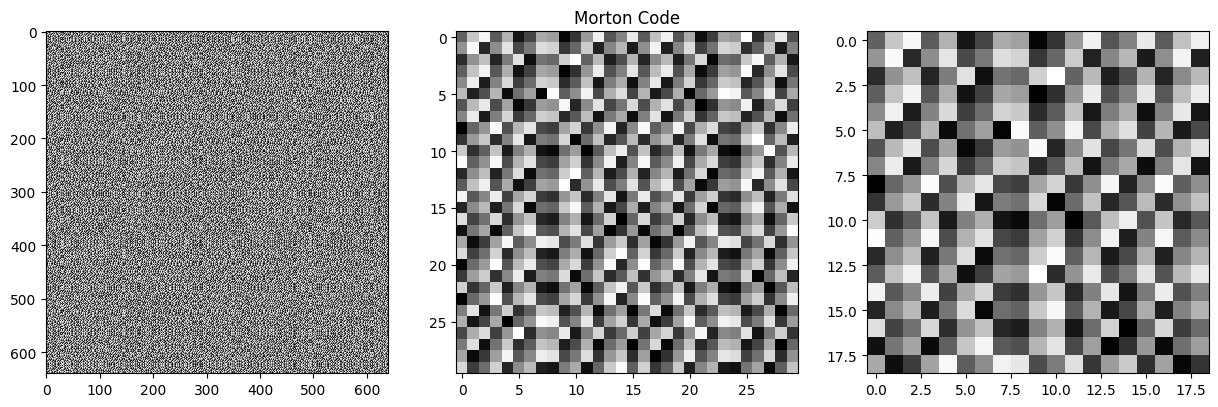

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15] # This is to adjust the image size on Jupyter
plt.subplot(131)
plt.imshow(ngrid[0:640,0:640], cmap='gray', interpolation='nearest')
plt.subplot(132)
plt.title('Morton Code')
plt.imshow(ngrid[0:30,0:30], cmap='gray', interpolation='nearest')
plt.subplot(133)
plt.imshow(ngrid[0:19,0:19], cmap='gray', interpolation='nearest')
plt.show()

# Interpolation


- `unitclamp(x)`: This function takes a float value x as input and returns a value between 0 and 1, inclusive, by restricting the input to that range. If the input is less than 0, it returns 0; if it is greater than 1, it returns 1; otherwise, it returns the input.
- `unitwrap(x)`: This function takes a float value `x` as input and returns the fractional part of the input value in the range [0,1). It does this by subtracting the integer part of `x` from `x`. If `x` is negative, it adds 1 to the result to ensure that the returned value is in the range [0,1).
- `unitstep(x)`: This function takes a float value `x` as input and returns 0 if `x` is less than or equal to 0, and 1 otherwise.
- `unitrescale(xmin, xmax, x)`: This function linearly scales the float value `x` onto the range [0,1], based on the given minimum and maximum values `xmin` and `xmax`. It first asserts that xmin is less than xmax, and that all input values are of type float. It then calculates the scaled value by subtracting `xmin` from `x`, dividing by the range `xmax-xmin`, and returning the result.
- `unitlerp(a0, a1, t)`: This function performs linear interpolation between the float values `a0` and `a1`, using a mixing weight `t` that specifies the weight of the second value in the interpolation. The returned value is a linear combination of the two input values, with the weight of the second value given by t.
- `wrap(x0, x1, x)`: This function wraps the float value x within the range [x0, x1). It first asserts that x0 is less than x1, and then calculates the range length l as the difference between x1 and x0. It then calculates the "wrapped" value of x by subtracting x0 from x, dividing the result by l, taking the floor of the result, multiplying by l, and subtracting from x. The resulting value is in the range [x0, x1).
- `step(x, t)`: This function takes in two numerical arguments, `x` and `t`, and returns the output of `unitstep`. The step function essentially shifts the unitstep function by `t` units to the right along the x-axis. `step(x, t)` will return 1 when `x-t` is greater than or equal to zero.
- `clamp(mn, mx, val)`: This function "clamps" the input value val to a minimum value `mn` and a maximum value `mx`.
- `rescale(cmin, cmax, vmin, vmax, v)`: This function takes in five numerical arguments, `cmin, cmax, vmin, vmax`, and `v`. It calculates a scaling factor `alpha` based on the values of `v, vmin`, and `vmax`. Then it scales the range between `cmin` and `cmax` by `alpha` and returns the result.

In [ ]:
def unitclamp(x):
    # Restricts the given value x to [0,1]
    assert(type(x)==float)
    if x < 0:
        y = 0
    elif x > 1:
        y = 1
    else:
        y = x
    return y

def unitwrap(x):
    # Returns the fractional part in [0,1) of x
    assert(type(x)==float)
    y = x - int(x)
    if x > 0:
        return y
    else:
        return y + 1

def unitstep(x):
    # Returns 0 if x<0, 1 otherwise
    sgn = 1
    if x <= 0:
        sgn = 0
    return sgn

def unitrescale(xmin, xmax, x):
    # Linearly scale x onto [0,1]
    assert(xmin<xmax)
    assert(type(xmin)==float)
    assert(type(xmax)==float)
    assert(type(x)==float)
    return (x-xmin)/(xmax-xmin)

def unitlerp(a0, a1, t):
    # Linear interpolation with mixin weight, t
    assert(t >= 0 and t <= 1)
    return a0 * ( 1 - t ) + a1 * t

def wrap(x0, x1, x):
    assert (x0 < x1)
    l = x1 - x0
    xp = x - x0
    ix = np.floor(xp/l) * l
    r = xp - ix
    return r + x0

def step(x, t):
    return unitstep(x-t)

def clamp(mn, mx, val):
    if val<mn:
        val = mn
    elif val>mx:
        val = mx
    return val

def rescale(cmin, cmax, vmin, vmax, v):
    alpha = (v-vmin)/(vmax-vmin)
    return cmin + alpha * (cmax - cmin)

## **Testing code** ✅
- Let us now test our interpolation methods

In [ ]:
    print('Testing unitclamp')
    x = 0.7
    y = unitclamp(x)
    print(y)
    x = 10.7
    y = unitclamp(x)
    print(y)
    x = -7.7
    y = unitclamp(x)
    print(y)
    print('Testing unitwrap')
    x = 10.7
    y = unitwrap(x)
    print(y)
    x = -10.7
    y = unitwrap(x)
    print(y)
    print('Testing unitrescale')
    x = 11.
    xmin = 10.
    xmax = 20.
    y = unitrescale(xmin, xmax, x)
    print(y)
    print('Testing unitlerp')
    a0 = 7.
    a1 = 17.
    t = 0.5
    y = unitlerp(a0,a1,t)
    print(y)

Testing unitclamp
0.7
1
0
Testing unitwrap
0.6999999999999993
0.3000000000000007
Testing unitrescale
0.1
Testing unitlerp
12.0


# Grid of Distortions

The following function generates a pattern using simple interpolation functions we defined above. It can possibly be parameterised and generalised.

In [ ]:
def gridofdistortions(inputimg):
    assert type(inputimg) == np.ndarray
    sz = np.shape(inputimg)
    h, w = sz[0], sz[1]
    for ind in range(h):
        for jnd in range(w):
            r, c = float(ind)/h, float(jnd)/w
            wr = wrap(0, 0.194, r)
            wc = wrap(0, 0.250, c)
            dr = unitlerp(-0.02, 0, step(0.1, wc))
            dc = unitlerp(0.02, 0, step(0.1, wr))
            vr = step(wr, 0.05 + dr) - step(wr, 0.2 + dr)
            vc = step(wc, 0.05 + dc) - step(wc, 0.2 + dc)
            v = unitstep(1 - vr * vc) * 255
            inputimg[ind, jnd] = v
    return inputimg

## **Testing code** ✅
- Let us now try this patern generator

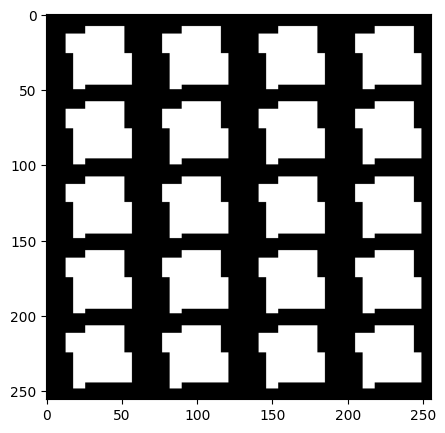

In [ ]:
  input = np.ones((256, 256))
  out = gridofdistortions(input)
  plt.rcParams['figure.figsize'] = [10, 5] # This is to adjust the image size on Jupyter
  plt.imshow(out, cmap='binary')
  plt.show()

# Interpolator variants

- The following variants are commonly used in interpolation (see the book for more detailed explanations)

In [ ]:
def valuehold(t):
    assert (t<=1) and (t>=0)
    interpval = 0
    if t==1:
        interpval=1
    return interpval

def nearestneighbour(t):
    assert (t<=1) and (t>=0)
    return unitstep(t - 0.5)

def linear(t):
    assert (t<=1) and (t>=0)
    return t

def cosine(t):
    assert (t<=1) and (t>=0)
    return 0.5 * (1 - np.cos(np.pi*t))

def smoothstep(t):
    assert (t<=1) and (t>=0)
    return -2 * t**3 + 3 * t**2

def smootherstep(t):
    assert (t<=1) and (t>=0)
    return 6 * t**5 - 15 * t**4 + 10*t**3


# Interpolating noise

- We will now have a look at how to interpolate noise using linear interpolation.
- We will see that smoother noise patterns can be generated but the Minecraft-y, block-y look does not yet diasppear as we will need more.

In [ ]:
def valueinterpolation1(a0, a1, t, infun):
    return unitlerp(a0, a1, infun(t))

def noiseinterpolate1d(xt, infun):
    xw = np.floor(xt)
    xf = xt - xw
    a0 = noiserandom(xw.astype(int))
    a1 = noiserandom(xw.astype(int) + 1)
    return valueinterpolation1(a0, a1, xf, infun)

def noiseinterpolate2d(xt, yt, infun):
    assert xt>=0 and yt>=0
    xw = np.floor(xt)
    xf = xt - xw
    yw = np.floor(yt)
    yf = yt - yw
    pt00 = np.array([xw, yw], np.int32)
    pt10 = np.array([xw+1, yw], np.int32)
    pt11 = np.array([xw+1, yw+1], np.int32)
    pt01 = np.array([xw, yw+1], np.int32)

    a00 = noiserandom(pt00)
    a10 = noiserandom(pt10)
    a01 = noiserandom(pt01)
    a11 = noiserandom(pt11)

    at0 = valueinterpolation1(a00, a10, xf, infun)
    at1 = valueinterpolation1(a01, a11, xf, infun)

    return valueinterpolation1(at0, at1, yf, infun)

def interpimg(xmin, xmax, ymin, ymax, rows, cols, infun):
    '''
    xmin, xmax, ymin, ymax: boundaries of the region at which interpolation will
                            be made
    rows, cols:             number of points at which interpolation will be made
    infun:                  interpolation function
    '''
    img = np.zeros((rows, cols))
    xs = np.linspace(xmin, xmax, rows)
    ys = np.linspace(ymin, ymax, cols)
    for ind in range(rows):
        for jnd in range(cols):
            vl = noiseinterpolate2d(xs[ind], ys[jnd], infun)
            img[ind, jnd] = vl
    return img

## **Testing code** ✅

- Let us first check if the fundamental function necessary for 2D noise interpolation works as intended

In [ ]:
val = noiseinterpolate2d(15, 17, smootherstep)
print(val)

0.028791427612304688


- Let us now generate a list of interpolation function names which we will subsequently use to interpolate our 2D noise

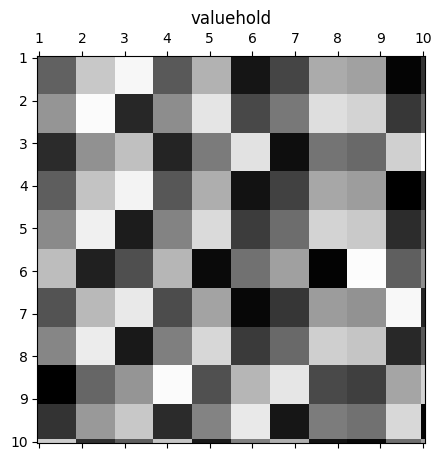

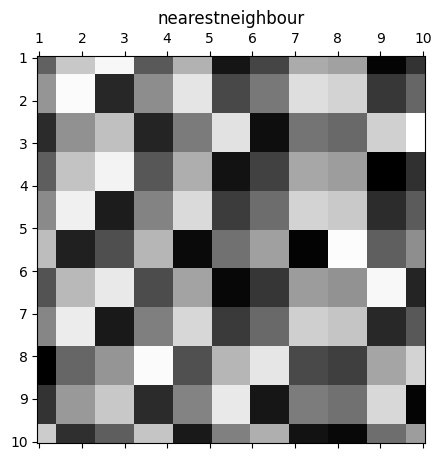

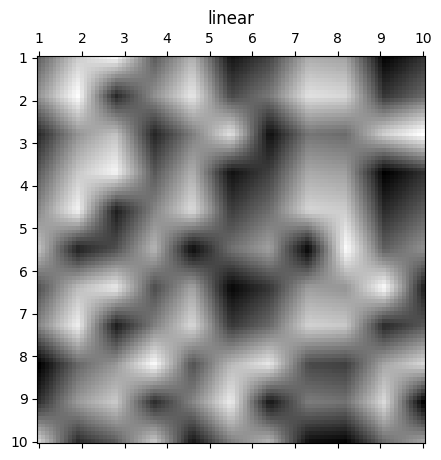

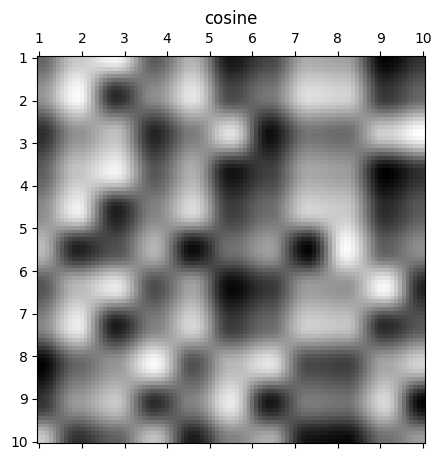

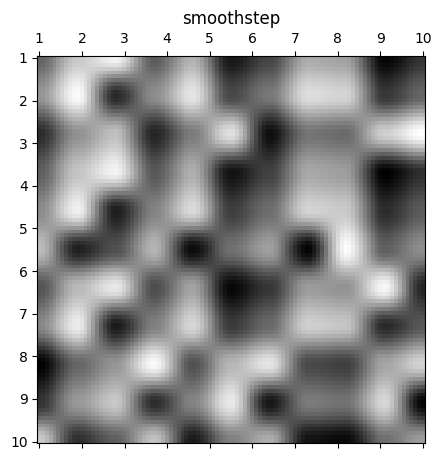

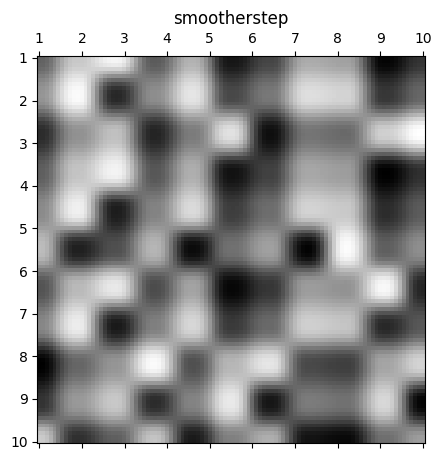

In [ ]:
fnlist = [valuehold, nearestneighbour, linear, cosine, smoothstep, smootherstep]

for fn in fnlist:
  img = interpimg(0, 10, 0, 10, 100, 100, fn)
  plt.matshow(img, cmap='gray', interpolation='none')
  ax = plt.gca()
  ax.set_xticks(np.arange(0, 100, 11))
  ax.set_yticks(np.arange(0, 100, 11))
  ax.set_xticklabels(np.arange(1, 11, 1))
  ax.set_yticklabels(np.arange(1, 11, 1))
  plt.title(str(fn.__name__))
  plt.show()

# Noise Composition

- **Noise composition** is a concept used in computer graphics, which involves the combination of different layers of noise create a new (and possibly more intersting) noise signal.
- **Turbulence** is a technique used in procedural noise generation to create more complex and visually interesting noise patterns. It involves applying multiple layers of noise with different frequencies and amplitudes to create a more detailed and textured result.
- In procedural noise generation, different types of noise functions (such as Perlin noise or Simplex noise) are combined and manipulated to create natural-looking textures, such as clouds, terrain, or fire. Turbulence is a way to enhance the realism of these textures by adding higher frequency noise to create small, intricate details.
- The basic idea behind turbulence is to add noise at different scales or frequencies to a base noise function. This is done by repeatedly applying the base noise function at different scales and amplitudes, and then summing the results. The resulting noise pattern has more detail and variation than the original, base noise function.

In [ ]:
def noisecomposition(xmin, xmax, ymin, ymax, rows, cols, infun, l=4, a0=0.5, f0=2):
    r = np.zeros((rows, cols))
    rmax = np.zeros((rows, cols))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + a * interpimg(xmin * f, xmax * f, ymin * f, ymax * f, rows, cols, infun)
        rmax = rmax + a
    return r / rmax

def noiseturbulence(xmin, xmax, ymin, ymax, rows, cols, infun, l=1, a0=0.5, f0=2):
    r = np.zeros((rows, cols))
    rmax = np.zeros((rows, cols))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + np.abs(a * interpimg(xmin * f, xmax * f, ymin * f, ymax * f, rows, cols, infun))
        rmax = rmax + np.abs(a)
    return 2 * (r / rmax) - 1

## **Testing code** ✅

- Let us first test the common noise composition function

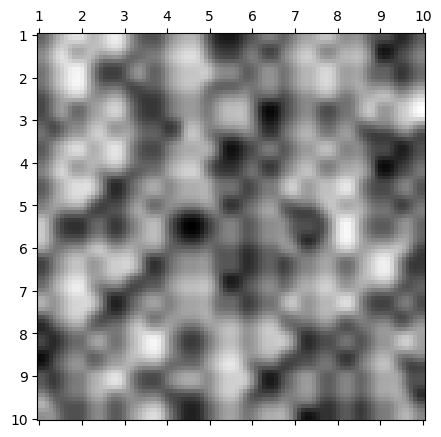

In [ ]:
img = noisecomposition(0, 10, 0, 10, 100, 100, smootherstep, l=2)
plt.matshow(img, cmap='gray', interpolation='none')
ax = plt.gca()
ax.set_xticks(np.arange(0, 100, 11))
ax.set_yticks(np.arange(0, 100, 11))
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))
plt.show()

- Turbulenced noise is more interesting though!

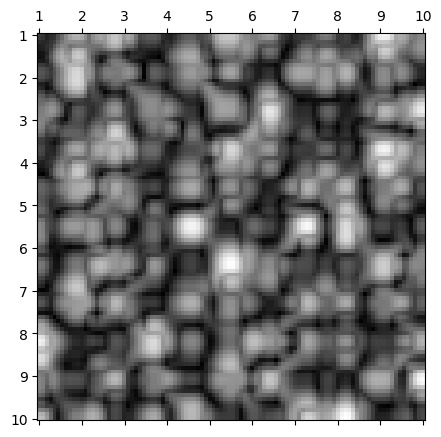

In [ ]:
img = noiseturbulence(0, 10, 0, 10, 100, 100, smootherstep, l=2)
plt.matshow(img, cmap='gray', interpolation='none')
ax = plt.gca()
ax.set_xticks(np.arange(0, 100, 11))
ax.set_yticks(np.arange(0, 100, 11))
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))
plt.show()

## Periodic noise

- We will now have a look at periodic noise
- The implementation is based on the creation of a cache of 4 tiles which match each other at sides and would be tiled to create a periodic noise pattern.

In [ ]:
def noiserandomtiled(cached, N, xmax, ymax, xoff, yoff, m=2**21-1, S0=117456):
    xp = (N[0] + xoff) % xmax
    yp = (N[1] + yoff) % ymax
    r = cached[xp, yp]
    if (np.isnan(r)):
        Nn = np.array([xp, yp], np.int32)
        r = noiserandom(Nn, m=2**21-1, S0=117456)
    cached[xp, yp] = r
    return r, cached

def noiseinterpolate2d_tiled(cached, xt, yt, xmax, ymax, xoff, yoff, infun):
    assert xt>=0 and yt>=0
    xw = np.floor(xt)
    xf = xt - xw
    yw = np.floor(yt)
    yf = yt - yw
    pt00 = np.array([xw, yw], np.int32)
    pt10 = np.array([xw+1, yw], np.int32)
    pt11 = np.array([xw+1, yw+1], np.int32)
    pt01 = np.array([xw, yw+1], np.int32)

    a00, cache = noiserandomtiled(cached[0], pt00, xmax, ymax, xoff, yoff)
    cached[0] = np.copy(cache)
    a10, cache = noiserandomtiled(cached[1], pt10, xmax, ymax, xoff, yoff)
    cached[1] = np.copy(cache)
    a01, cache = noiserandomtiled(cached[2], pt01, xmax, ymax, xoff, yoff)
    cached[2] = np.copy(cache)
    a11, cache = noiserandomtiled(cached[3], pt11, xmax, ymax, xoff, yoff)
    cached[3] = np.copy(cache)

    at0 = valueinterpolation1(a00, a10, xf, infun)
    at1 = valueinterpolation1(a01, a11, xf, infun)

    return valueinterpolation1(at0, at1, yf, infun), cached

def interpimg_tiled(xmax, ymax, xoff, yoff, numper, K, infun):
    '''
    xmin, xmax, ymin, ymax: boundaries of the region at which interpolation will
                            be made
    rows, cols:             number of points at which interpolation will be made
    infun:                  interpolation function
    '''
    img = np.zeros((K, K))
    xs = np.linspace(0, numper * xmax, K)
    ys = np.linspace(0, numper * ymax, K)
    rows = numper * xmax
    cols = numper * xmax
    cached = [np.zeros((rows, cols)) * np.nan, np.zeros((rows, cols)) * np.nan, np.zeros((rows, cols)) * np.nan, np.zeros((rows, cols)) * np.nan]
    for ind in range(K):
        for jnd in range(K):
            vl, cache = noiseinterpolate2d_tiled(cached, xs[ind], ys[jnd], xmax, ymax, xoff, yoff, infun)
            img[ind, jnd] = vl
            cached[0] = np.copy(cache[0])
            cached[1] = np.copy(cache[1])
            cached[2] = np.copy(cache[2])
            cached[3] = np.copy(cache[3])
    return img

## **Testing code** ✅

- Observe the periodic pattersn in the generated noise.
- You can get any $10\times{}10$ tile and use it to periodically extend the noise

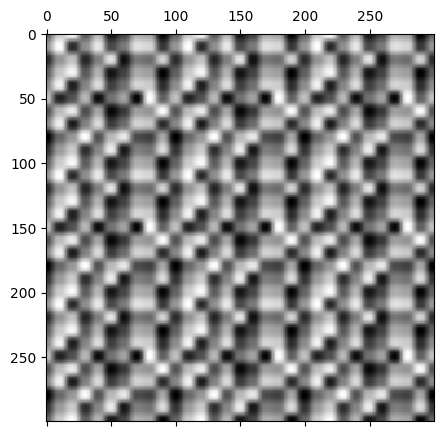

In [ ]:
img = interpimg_tiled(10, 10, 0, 0, 3, 300, smootherstep)
plt.matshow(img, cmap='gray', interpolation='none')
plt.show()

# Perlin Noise

### TRIVIA
In 1996, Ken Perlin was recognized with an Academy Award for Technical Achievement by the Academy of Motion Picture Arts and Sciences. This award was given to him for his contribution to the development of Perlin noise. Perlin noise was created by Perlin with the specific goal of producing more realistic-looking textures on computer-generated surfaces for use in motion picture visual effects.

Perlin's interest in developing natural-looking textures stemmed from his work on the Walt Disney Productions' 1982 feature film TRON. During this project, Perlin developed a significant portion of the software needed to create the film's groundbreaking visual effects. However, he found that the textures produced by the software were not realistic enough for the film's needs. This inspired Perlin to develop Perlin noise, a technique that added randomness to computer-generated textures, resulting in more natural-looking surfaces.

Perlin's contribution to the field of computer graphics has been significant, and his development of Perlin noise has been widely adopted in many different areas of computer graphics, including video games, animation, and virtual reality. By adding Perlin noise to textures, computer-generated environments can appear more natural and organic, making them more immersive and believable for viewers.

- We present several functions used in generating Perlin noise:
  1. `positioninunitcircle` gives the coordinates of a uniformly random position inside the unit circle.
  2. `randomnormal` gives a normally distributed point inside the unit circle
  3. `randomonunitsphere` is an extension to N dimensions
  4. Finally, we have three different flavours of Perlin noise: `vanillaperlin`, `composedperlin` and `turbulencedperlin`

In [ ]:
def positioninunitcircle():
    while True:
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1
        s = x**2 + y**2
        if s>0 and s<1:
            break
    return x, y, s

def randomnormal_01pair():
    x, y, s = positioninunitcircle()
    if isclose(s,0):
        return np.array([0.,0.])
    c = np.sqrt(-2*np.log(s)/s)
    x0 = x * c
    x1 = y * c
    return np.array([x0, x1])

def randomonunitsphere(numdim, seed):
    np.random.seed(seed)
    d = numdim
    R = np.zeros(numdim)
    xi = 0
    while 2<=d:
        d -= 2
        x, y, s = positioninunitcircle()
        if isclose(s,0):
            R[d] = 0
            R[d + 1] = 0
        else:
            q = -2 * np.log(s)
            xi += q
            c = np.sqrt(q/s)
            R[d] = x * c
            R[d + 1] = y * c
    if d==1:
        x, y, s = positioninunitcircle()
        if isclose(s,0):
            R[0] = 0
        else:
            R[0] = x * np.sqrt(-2 * np.log(s) / s)
            xi += R[0]**2
    if isclose(xi, 0):
        return randomonunitsphere(numdim)
    R /= np.sqrt(xi)
    return R

def noiserandomvector(N, n):
    seed = morton(N)
    R = randomonunitsphere(n, seed)
    return R

def noiseperlin(x, y):
    assert x>=0 and y>=0
    xw = np.floor(x)
    yw = np.floor(y)
    xf = x - xw
    yf = y - yw
    a00 = noiserandomvector(np.array([xw, yw], np.int32), 2)
    a10 = noiserandomvector(np.array([xw + 1, yw], np.int32), 2)
    a01 = noiserandomvector(np.array([xw, yw + 1], np.int32), 2)
    a11 = noiserandomvector(np.array([xw + 1, yw + 1], np.int32), 2)
    pt = np.array([x, y])
    v00 = pt - np.array([xw, yw])
    v10 = pt - np.array([xw + 1, yw])
    v01 = pt - np.array([xw, yw + 1])
    v11 = pt - np.array([xw + 1, yw + 1])
    d00 = np.sum(a00 * v00)
    d01 = np.sum(a01 * v01)
    d10 = np.sum(a10 * v10)
    d11 = np.sum(a11 * v11)
    ds0 = valueinterpolation1(d00, d10, xf, smootherstep)
    ds1 = valueinterpolation1(d01, d11, xf, smootherstep)
    val = valueinterpolation1(ds0, ds1, yf, smootherstep)
    return val

def vanillaperlin(xmin, xmax, ymin, ymax, Kx, Ky):
    img = np.zeros((Kx, Ky))
    xgrid = np.linspace(xmin, xmax, Kx)
    ygrid = np.linspace(ymin, ymax, Ky)
    for ind in range(Kx):
        for jnd in range(Ky):
            img[ind, jnd] = noiseperlin(xgrid[ind], ygrid[jnd])
    return img

def composedperlin(xmin, xmax, ymin, ymax, Kx, Ky, l, a0, f0):
    r = np.zeros((Kx, Ky))
    rmax = np.zeros((Kx, Ky))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + a * vanillaperlin(xmin * f, xmax * f, ymin * f, ymax * f, Kx, Ky)
        rmax = rmax + a
    return r / rmax

def turbulencedperlin(xmin, xmax, ymin, ymax, Kx, Ky, l, a0, f0):
    r = np.zeros((Kx, Ky))
    rmax = np.zeros((Kx, Ky))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + np.abs(a * vanillaperlin(xmin * f, xmax * f, ymin * f, ymax * f, Kx, Ky))
        rmax = rmax + a
    return r / rmax

## **Testing code** ✅

- We will test all three flavours of Perlin noise: observe the textural differences.

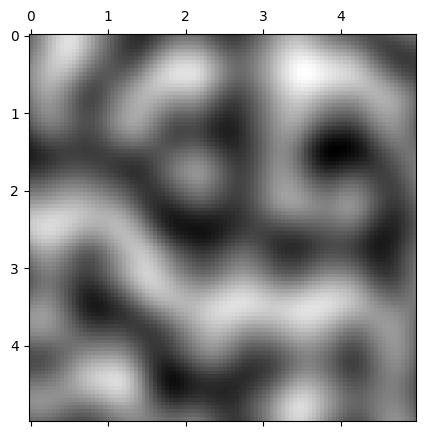

In [ ]:
img = vanillaperlin(0, 5, 0, 5, 100, 100)
plt.matshow(img, cmap='gray', interpolation='none')
ax = plt.gca()
ax.set_xticks(np.arange(0, 100, 20))
ax.set_yticks(np.arange(0, 100, 20))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_yticklabels(np.arange(0, 5, 1))
plt.show()

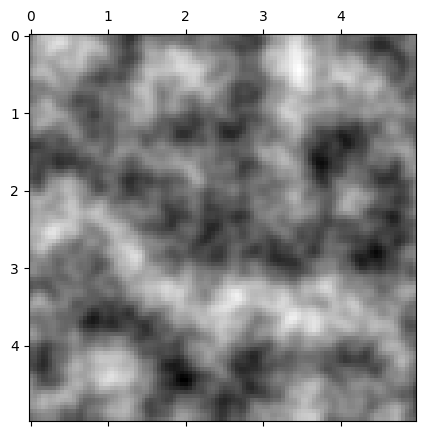

In [ ]:
img = composedperlin(0, 5, 0, 5, 100, 100, 3, 0.5, np.sqrt(5))
plt.matshow(img, cmap='gray', interpolation='none')
ax = plt.gca()
ax.set_xticks(np.arange(0, 100, 20))
ax.set_yticks(np.arange(0, 100, 20))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_yticklabels(np.arange(0, 5, 1))
plt.show()

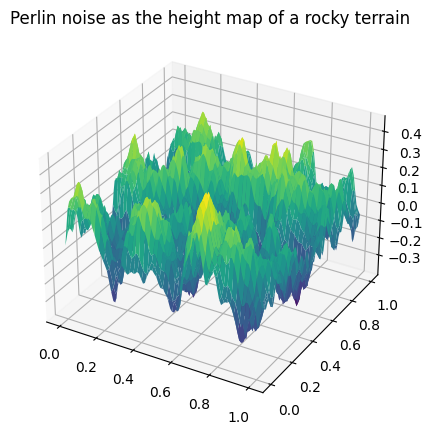

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(0, 1, img.shape[0])
y = np.linspace(0, 1, img.shape[1])
xx, yy = np.meshgrid(x, y)
ax.plot_surface(xx, yy, img,cmap='viridis', edgecolor='none')
ax.set_title('Perlin noise as the height map of a rocky terrain')
plt.show()

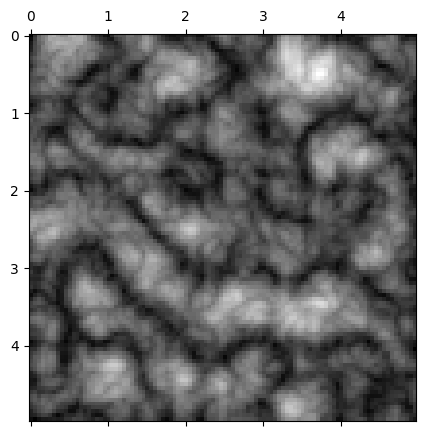

In [ ]:
img = turbulencedperlin(0, 5, 0, 5, 100, 100, 3, 0.5, np.sqrt(5))
plt.matshow(img, cmap='gray', interpolation='none')
ax = plt.gca()
ax.set_xticks(np.arange(0, 100, 20))
ax.set_yticks(np.arange(0, 100, 20))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_yticklabels(np.arange(0, 5, 1))
plt.show()

# Worley Noise

- Worley noise depends on the creation of uniformly distributed $N$ random points in a given region from a Poisson distribution as in `gridneighbours`
- For every pixel at which we will calculate the noise, we find the $n$ nearest points, and then use their distances to compose the Worley noise.
- We present two versions: `vanillaworley` and `turbulencedworley`

In [ ]:
def gridneighbours(x, y, n, mu, dmax, xw, yw, dflag='euclid', S0=0):
    R = []
    p = np.array([x, y]) # Position of interest
    m = np.array([xw + 0.5, yw + 0.5]) # Centroid
    if (dmax + radius(dflag)) < distance(p, m, dflag):
        return R # This region will not contribute
    N = morton(np.array([xw, yw], np.int8)) # The seed will be randomly generated
    np.random.seed(N + S0)
    c = np.random.poisson(mu) # We will use a pre-made Poisson number generator
    c = clamp(1, 9, c)
    for ind in range(c):
        xs = np.random.rand() # We will use a pre-made uniform random number generator
        ys = np.random.rand() # We will use a pre-made uniform random number generator
        q = np.array([xw + xs, yw + ys])
        if distance(p, q, dflag) < dmax:
            r = (distance(p, q, dflag), q) # Create a tuple that includes both the distance and the feature point
            R.append(r)
    return sorted(R)[:min(n, len(R))] # Get the n nearest points

def neighbours2(x, y, n, mu, dflag='euclid', S0=1):
    xw = np.floor(x)
    yw = np.floor(y)
    dmax = 4 * radius(dflag) # Cover all NSEW neigbouring grid positions
    R = gridneighbours(x, y, n, mu, dmax, xw, yw, dflag, S0)
    if n <= len(R):
        dmax = R[n-1][0]
    for ind in range(-1,2): # For the all the possible grid neighbours [Up, Down]
        for jnd in range(-1,2): # For the all the possible grid neighbours [Left, Right]
            if (ind, jnd)!=(0,0): # Except the present grid region
                R += gridneighbours(x, y, n, mu, dmax, xw + ind, yw + jnd, dflag, S0) # Add new neighbours
                R = sorted(R)[:min(n, len(R))] # Some of the new neighbours could possibly be closer than the old ones
                if n<=len(R):
                    dmax = R[n-1][0] # Shrink if necessary
    # R = sorted(R)[:min(n, len(R))]
    return R

def noiseworley2(x, y, n, mu, infun, ind, dflag='euclid', vmin=0, vmax=0.2):
    xs = x + 2
    ys = y + 2
    N = neighbours2(xs, ys, n, mu, dflag)
    v = infun(N, ind)
    return rescale(-1, 1, vmin, vmax, clamp(vmin, vmax, v))

def distance(p, q, flag='euclid'):
    if flag == 'euclid':
        return np.sqrt(np.sum((p - q)**2))
    elif flag == 'manhattan':
        return np.sum(np.abs(p - q))
    elif flag == 'max':
        return np.max(np.abs(p - q))
    elif flag == 'cheby':
        return cheby(p, q)
    else:
        raise ValueError('distance(): flag can only be euclid, manhattan, or max')

def radius(flag='euclid'):
    if flag=='euclid':
        return 1/np.sqrt(2)
    elif flag=='manhattan':
        return 1
    elif flag=='max':
        return 0.5
    elif flag == 'cheby':
        return 0.5
    else:
        raise ValueError('radius(): flag can only be \'euclid\', \'manhattan\', \'cheby\', or \'max\'')

def indfeat(N, ind):
    val = N[ind][0]
    return val


def vanillaworley(xmin, xmax, ymin, ymax, Kx, Ky, n=3, mu=3, infun=indfeat, indf=0, dflag='euclid', vmin=0, vmax=0.5):
    xg = np.linspace(xmin, xmax, Kx)
    yg = np.linspace(ymin, ymax, Ky)
    W = np.zeros((Kx, Ky))
    N = []
    for ind in range(Kx):
        for jnd in range(Ky):
            W[ind, jnd] = noiseworley2(xg[ind], yg[jnd], n, mu, infun, indf, dflag, vmin, vmax)
    return W

def turbulencedworley(xmin, xmax, ymin, ymax, Kx, Ky, l=3, a0=0.03, f0=1.97, n=3, mu=3, infun=indfeat, indf=0, dflag='euclid', vmin=0, vmax=0.5):
    r = np.zeros((Kx, Ky))
    rmax = np.zeros((Kx, Ky))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + np.abs(a * vanillaworley(xmin, xmax, ymin, ymax, Kx, Ky, n=n, mu=mu, indf=indf, dflag=dflag))
        rmax = rmax + a
    return r / rmax

## **Testing code** ✅

- We first test `vanillaworley`...



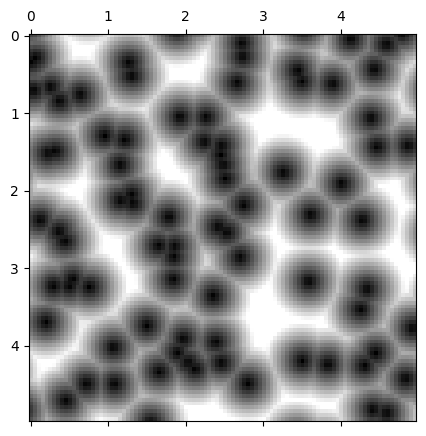

In [ ]:
img = vanillaworley(0, 5, 0, 5, 100, 100, 3, 3, indf=0, dflag='euclid')
plt.matshow(img, cmap='gray', interpolation='none')
ax = plt.gca()
ax.set_xticks(np.arange(0, 100, 20))
ax.set_yticks(np.arange(0, 100, 20))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_yticklabels(np.arange(0, 5, 1))
plt.show()

- ... and then `turbulencedworley`

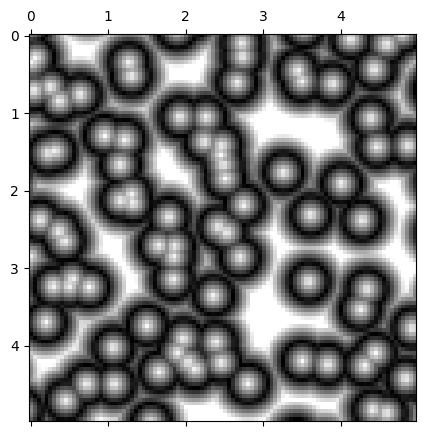

In [ ]:
    img = turbulencedworley(0, 5, 0, 5, 100, 100, 6, 9, indf=0, dflag='euclid')
    plt.matshow(img, cmap='gray', interpolation='none')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 100, 20))
    ax.set_yticks(np.arange(0, 100, 20))
    ax.set_xticklabels(np.arange(0, 5, 1))
    ax.set_yticklabels(np.arange(0, 5, 1))
    plt.show()

# **PROGRAMMING ASSIGNMENT #2**
## **Fall 2023/24 Semester**


- Curl noise is a pseudo-fluid noise algorithm that was announced in 2007 by Robert Bridson. It is used to create randomly varying velocity fields.
- The algorithm has the benefit of being *incompressible*, meaning that particles will generally stay separate.
- The name “curl” comes from the curl function used to compute it (Vector calculus anyone?)
- Curl noise has been used in various applications such as procedural fluid flow, and particle systems
- It is typically implemented using simplex noise as the potential function but Perlin noise can as well be used.
- See https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph2007-curlnoise.pdf


**GRADING:**
1. Correct implentation of the ```curlnoise()``` function using the Eqs 1 and 2 in the provided paper and the simplex/perlin noise (see colab notebook) (25/100)
2. Correct interpretation of the ```curlnoise()``` output for plotting (15/100)
3. Results are animated: convincing fluidic motion in the animated plot (30/100)
4. Code works with default arguments (10/100)
5. Code carries out necessary checks on inputs via proper assertions (10/100)
6. Code is properly commented on, explained and documented (10/100)

**Notes:**
1. You are free to use chatGPT for help, you should not use code generated by chatGPT directly and you should mention which part of the code is chatGPT it in the comments. Your code will be checked for verbatim copying from chatGPT.
2. You are not allowed to use external modules/libraries in your implementations, but you can use them for testing your code.
3. You will upload your submission as a Python notebook to ODTUClass.

#### **Animation in Google Colab**
Here is a useful tutorial. You can find others...
https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/A.03-Animation-in-Jupyter-Notebooks.ipynb

(c) Huseyin Hacihabiboglu, 2022-2023